In [18]:
# Iowa, USA lat and long for where there is lots of vegetation
lat, lon = 42.0325, -93.5815
start = "2023-01-01"
end = "2023-12-31"

In [19]:
import pystac_client

STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"  # Sentinel-2 Level-2A collection

catalog = pystac_client.Client.open(STAC_API)
search = catalog.search(
    collections=[COLLECTION],
    bbox=(lon - 0.1, lat - 0.1, lon + 0.1, lat + 0.1), 
    max_items=100,
    datetime=f"{start}/{end}",
    query={"eo:cloud_cover": {"lt": 20}},
)

all_items = search.get_all_items()

items = []
dates = []
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

Found 48 items


In [20]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Extract EPSG projection from the first item
epsg = all_items[0].properties["proj:epsg"]

# Convert Iowa's lat/lon to the coordinate system of the satellite data
poidf = gpd.GeoDataFrame(
    pd.DataFrame(),
    crs="EPSG:4326",
    geometry=[Point(lon, lat)],
).to_crs(epsg)

coords = poidf.iloc[0].geometry.coords[0]

size = 128
gsd = 10     # Ground sampling distance for Sentinel-2 (10m/pixel)

bounds = (
    coords[0] - (size * gsd) / 2,
    coords[1] - (size * gsd) / 2,
    coords[0] + (size * gsd) / 2,
    coords[1] + (size * gsd) / 2,
)


In [21]:
from rasterio.enums import Resampling
stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=gsd,
    dtype="float64",
    rescale=False,
    fill_value=0,
    assets=["blue", "green", "red", "nir"],
    resampling=Resampling.nearest,
)

print(stack)

stack = stack.compute()

<xarray.DataArray 'stackstac-256e450d872b48c8309cd759f3c80c20' (time: 48,
                                                                band: 4,
                                                                y: 128, x: 128)> Size: 25MB
dask.array<fetch_raster_window, shape=(48, 4, 128, 128), dtype=float64, chunksize=(1, 1, 128, 128), chunktype=numpy.ndarray>
Coordinates: (12/54)
  * time                                     (time) datetime64[ns] 384B 2023-...
    id                                       (time) <U24 5kB 'S2A_15TVG_20230...
  * band                                     (band) <U5 80B 'blue' ... 'nir'
  * x                                        (x) float64 1kB 4.512e+05 ... 4....
  * y                                        (y) float64 1kB 4.654e+06 ... 4....
    constellation                            <U10 40B 'sentinel-2'
    ...                                       ...
    proj:shape                               object 8B {10980}
    gsd                           

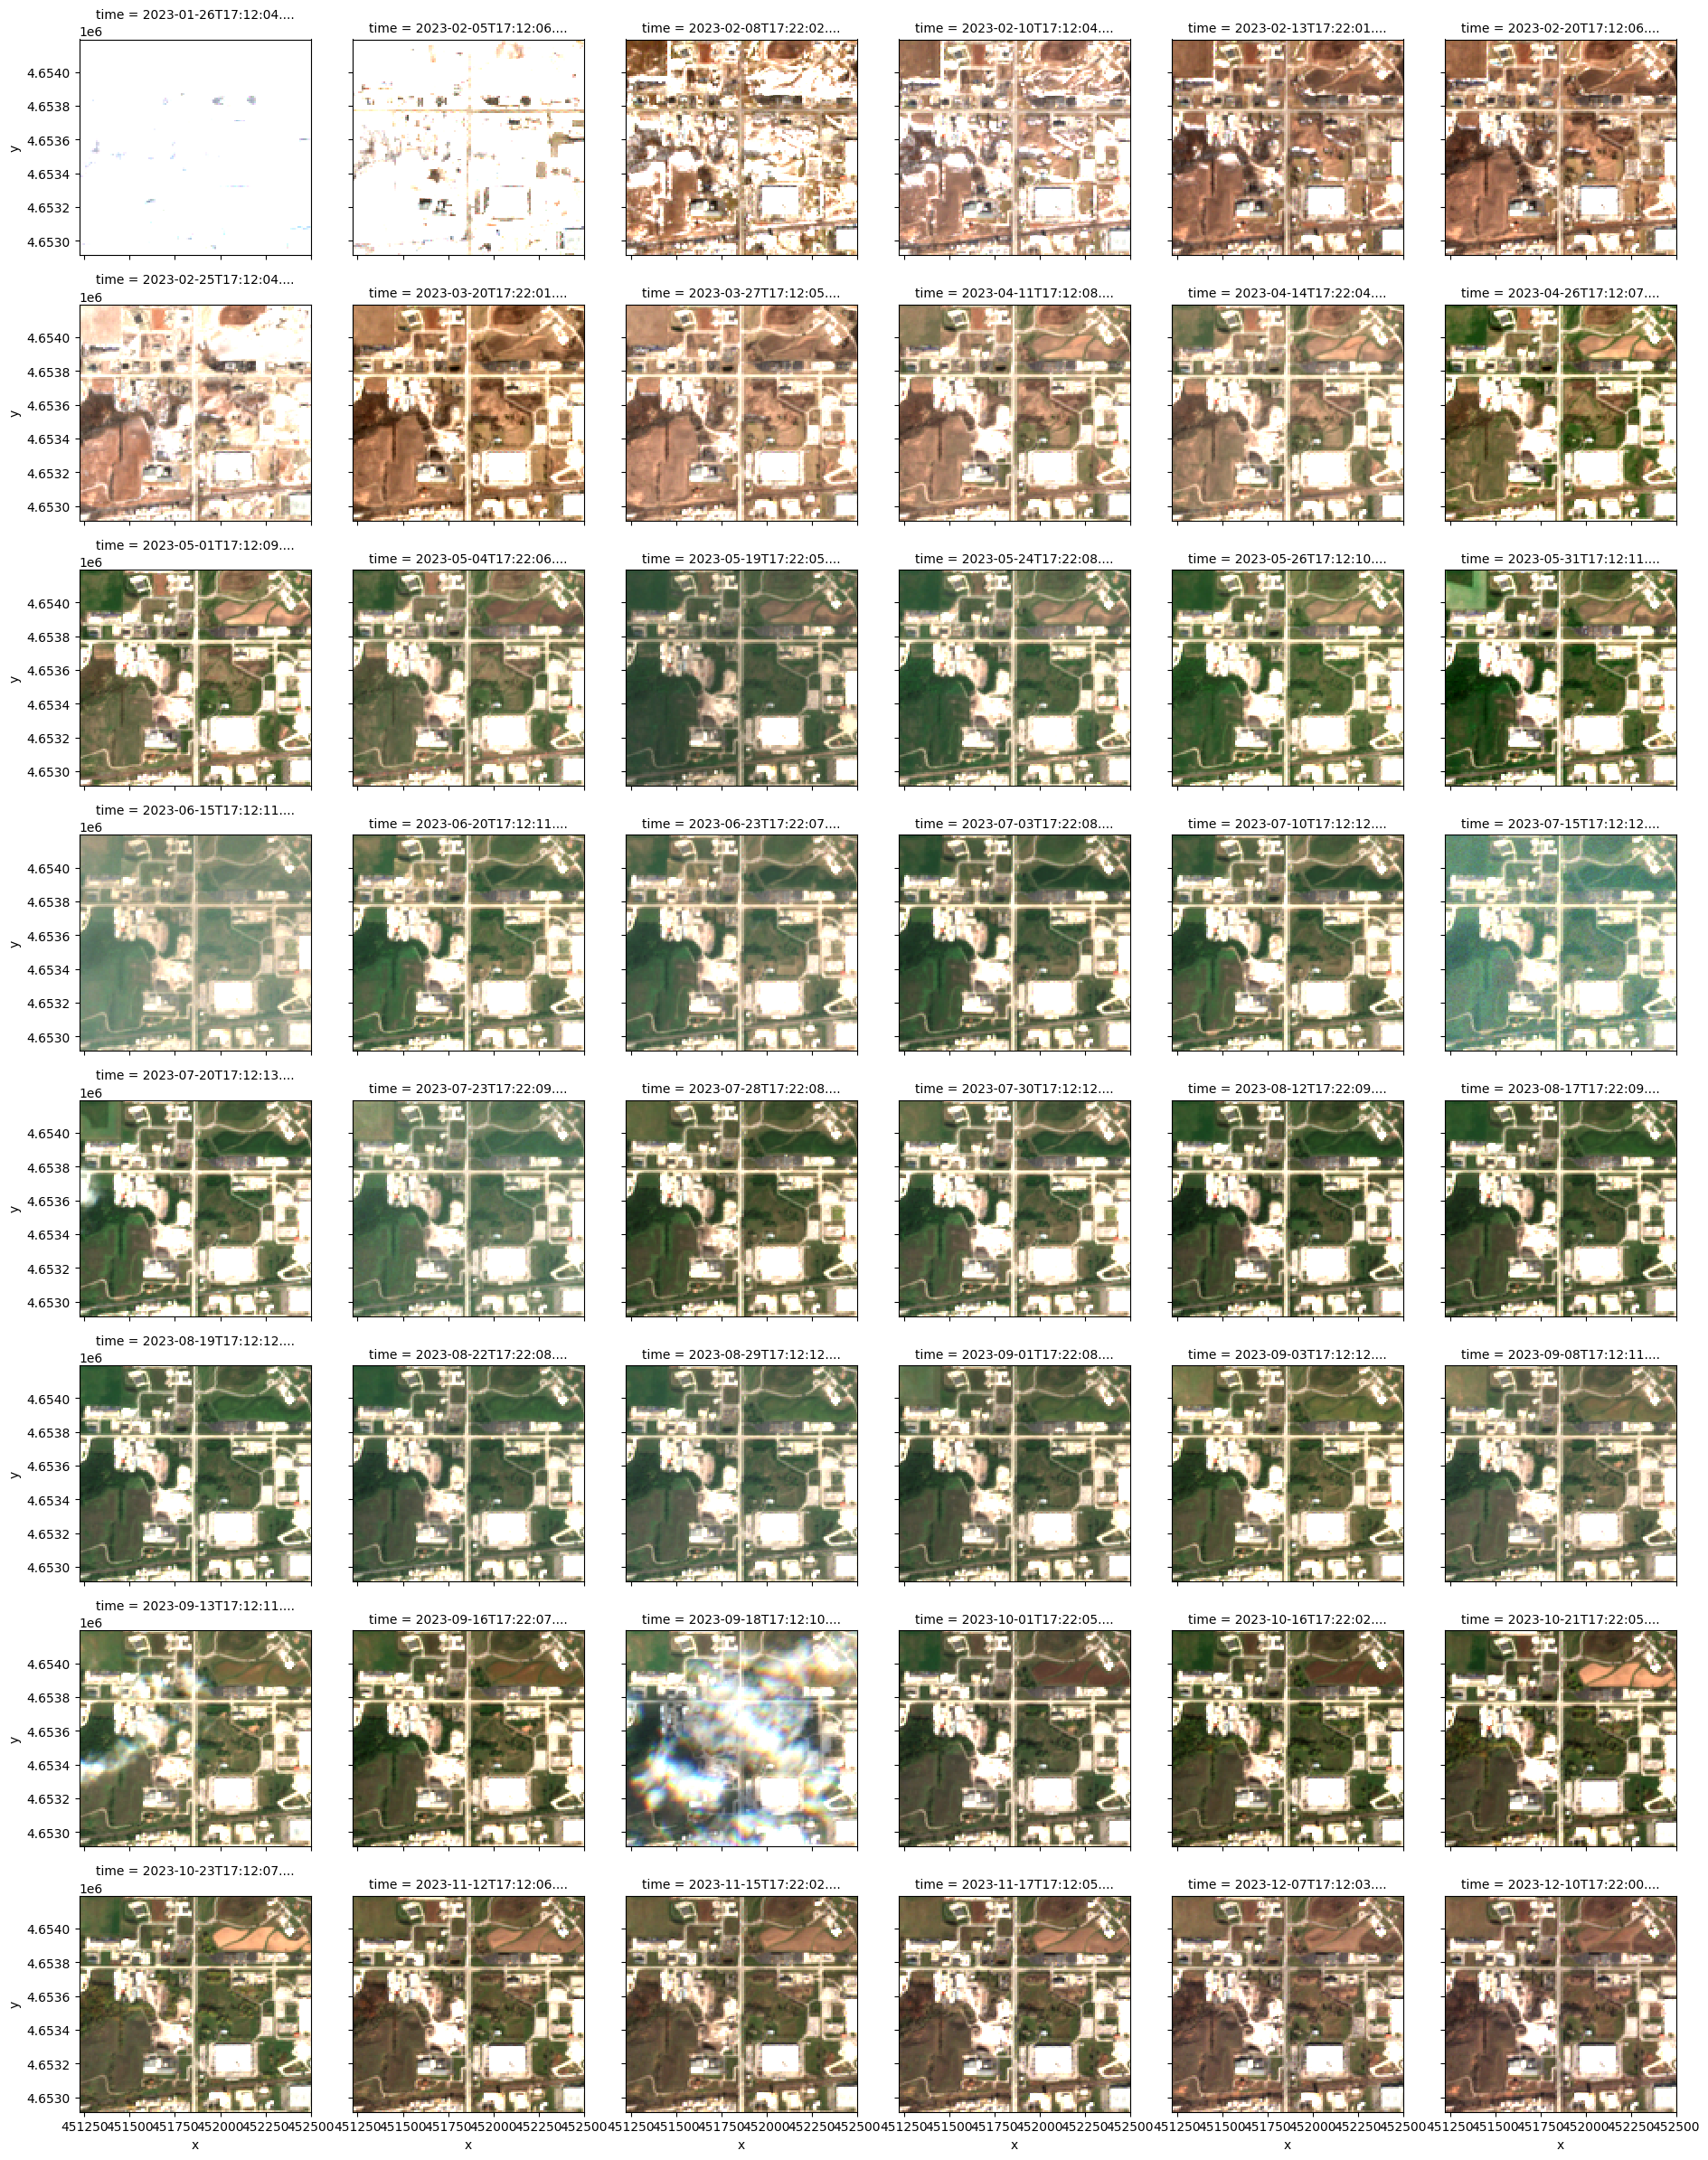

In [22]:
stack.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
)

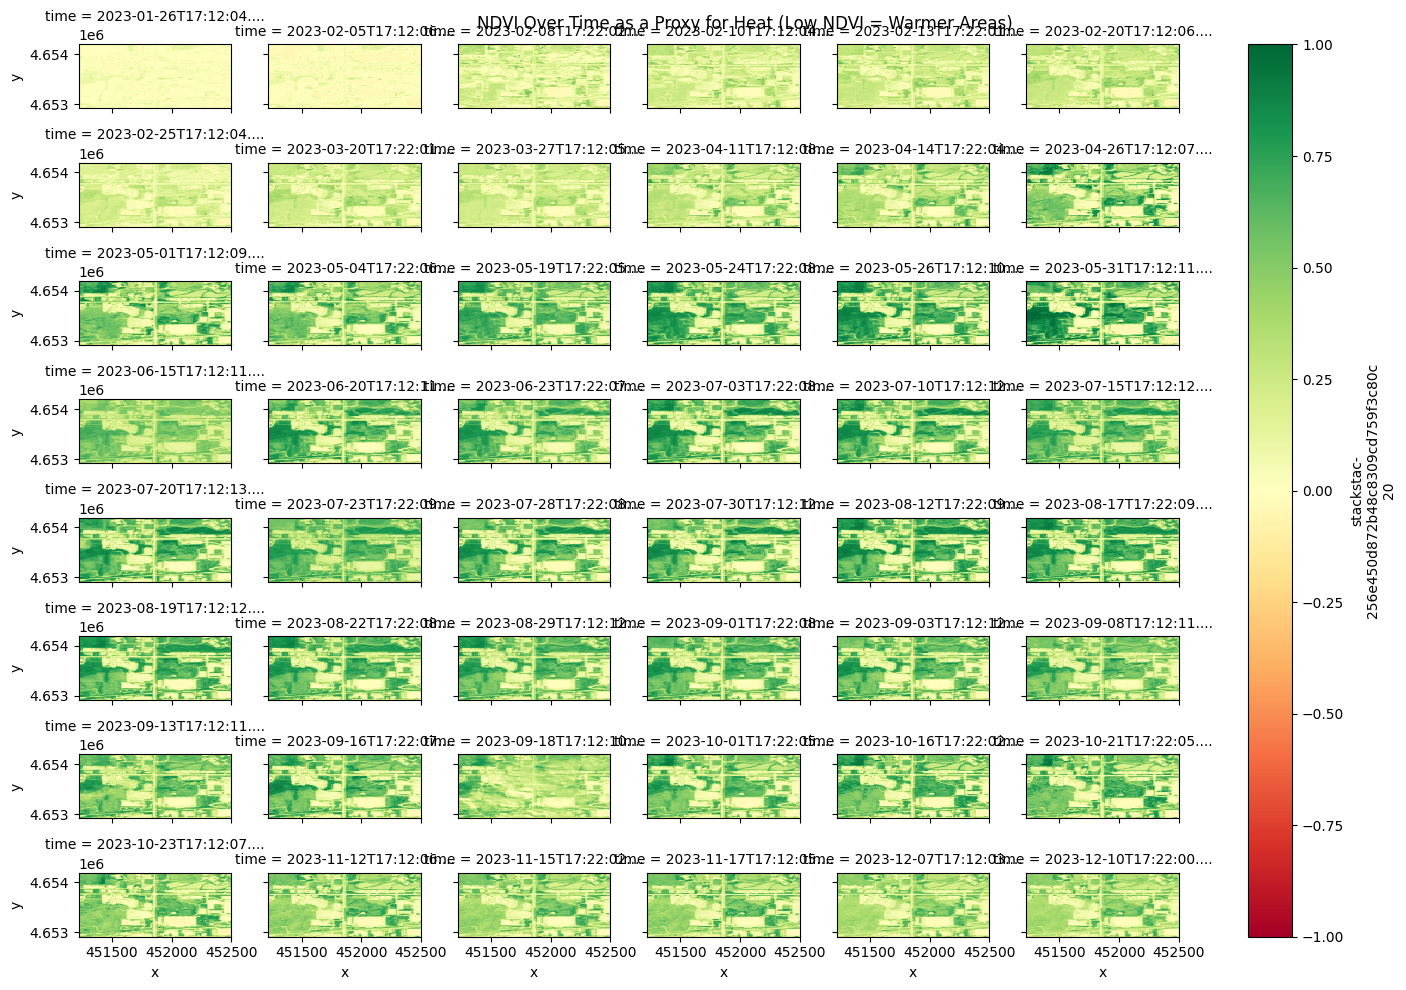

In [23]:
# Calculate NDVI
ndvi = (stack.sel(band="nir") - stack.sel(band="red")) / (stack.sel(band="nir") + stack.sel(band="red"))

# Plot NDVI as a proxy for heat levels over time
ndvi.plot.imshow(
    row="time",
    cmap="RdYlGn",  # Red-Yellow-Green colormap where red indicates low NDVI (hotter) and green indicates high NDVI (cooler)
    vmin=-1,
    vmax=1,
    col_wrap=6,
    figsize=(15, 10)
)
plt.suptitle("NDVI Over Time as a Proxy for Heat (Low NDVI = Warmer Areas)")
plt.show()
